In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import datetime
import seaborn as sns

import statsmodels.stats.diagnostic as dg
import statsmodels.tools.tools as ct
import statsmodels.regression.linear_model as rg
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [31]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [32]:
START_DATE = "2013-01-02"
END_DATE = "2021-12-31"
SPLIT_FACTOR = 0.85

# Data Reading

In [33]:
raw_data = pd.read_csv(r'data\stocks_df.csv', header=0, sep = ",", parse_dates=[0], date_parser=parser)
mask = (raw_data['Date'] >= START_DATE) & (raw_data['Date'] <= END_DATE)
stocks_df = raw_data.loc[mask]
stocks_df.reset_index(inplace = True, drop = True)
stocks_df

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,2013-01-02,1462.420044,13412.54980,3112.260010,8632.009766,14.680000,2269.127930,1.319784,86.599998,1.624695,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,2013-01-03,1459.369995,13391.36035,3100.570068,8607.790039,14.560000,2269.127930,1.318218,87.275002,1.625250,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,2013-01-04,1466.469971,13435.20996,3101.659912,8667.679688,13.830000,2276.991943,1.303271,87.739998,1.608234,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,2013-01-07,1461.890015,13384.29004,3098.810059,8636.910156,13.790000,2285.364014,1.306745,88.197998,1.606787,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,2013-01-08,1457.150024,13328.84961,3091.810059,8604.379883,13.620000,2276.070068,1.312508,87.252998,1.612201,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,4791.189941,36302.37891,15871.259770,17141.089840,17.680000,3615.969971,1.132426,114.333000,1.340430,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,2021-12-28,4786.350098,36398.21094,15781.719730,17134.160160,17.540001,3630.112061,1.133003,114.792000,1.344267,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,2021-12-29,4793.060059,36488.62891,15766.219730,17149.929690,16.950001,3597.000000,1.131478,114.773003,1.343328,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,2021-12-30,4778.729980,36398.07813,15741.559570,17164.240230,17.330000,3619.189941,1.136015,114.947998,1.349879,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73


In [35]:
stocks_df.dtypes

Date      datetime64[ns]
^GSPC            float64
^DJI             float64
^IXIC            float64
^NYA             float64
               ...      
LIN              float64
TXN              float64
NEE              float64
T10YIE           float64
T5YIE            float64
Length: 87, dtype: object

In [36]:
stocks_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
^GSPC,2267.0,2592.580396,781.401906,1457.150024,2020.714966,2432.459961,2935.729981,4793.060059
^DJI,2267.0,22382.318566,5996.247598,13328.849610,17323.235355,21328.470700,26327.334960,36488.628910
^IXIC,2267.0,7115.422644,3284.071455,3091.810059,4727.080079,6234.410156,8118.175049,16057.440430
^NYA,2267.0,11933.662107,1996.464400,8604.379883,10515.500000,11514.400390,12884.955075,17310.509770
^VIX,2267.0,17.000362,7.122941,9.140000,12.840000,14.910000,18.884999,82.690002
...,...,...,...,...,...,...,...,...
LIN,2267.0,152.325847,64.350183,85.154175,105.852566,121.700264,184.508926,346.429993
TXN,2267.0,85.135160,48.235800,25.013260,43.962057,72.645607,111.169167,201.289993
NEE,2267.0,38.130828,21.319112,13.006111,20.255817,31.979395,53.418072,93.360001
T10YIE,2267.0,2.171544,0.453418,0.040000,2.020000,2.320000,2.440000,2.760000


In [37]:
company_df = pd.read_csv(r'data\company_dataset_ts.csv', header=0, parse_dates=[0], date_parser=parser)
mask = (company_df['Date'] >= START_DATE) & (company_df['Date'] <= END_DATE)
company_df = company_df.loc[mask]
company_df.reset_index(inplace = True, drop = True)
company_df = pd.concat([company_df.iloc[:, 0:2], company_df.iloc[:, 32:]], axis=1)
company_df

,Date,Adj Close,High,Low,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold
0,2013-01-02,22.333015,28.680000,28.049999,28.139999,28.670000,6677100.0,21.331152,21.544037,21.318136,67.940932,0.248235,28.276532,26.462801
1,2013-01-03,22.153860,28.760000,28.299999,28.760000,28.440001,3970700.0,21.405943,21.617482,21.379340,64.147275,0.281482,28.441684,26.473316
2,2013-01-04,22.761452,29.290001,28.459999,28.500000,29.219999,5842400.0,21.529171,21.782178,21.472446,70.220399,0.352791,28.711065,26.420268
3,2013-01-07,21.818907,29.100000,27.930000,29.100000,28.010000,8339200.0,21.555511,21.842271,21.520297,54.732007,0.329450,28.761600,26.540400
4,2013-01-08,22.075964,28.360001,27.900000,27.930000,28.340000,3880400.0,21.602825,21.936860,21.580389,57.486147,0.327915,28.805516,26.614484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,66.089996,65.250000,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,58.105626,0.302337,66.388560,62.033441
2263,2021-12-28,66.930000,66.980003,66.000000,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,61.772180,0.438992,66.711888,61.891113
2264,2021-12-29,67.010002,67.459999,66.870003,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,62.104439,0.547438,67.116617,61.917051
2265,2021-12-30,66.860001,67.410004,66.830002,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,61.033303,0.614197,67.396706,62.084962


# Data Analysing and Visualisation 

In [38]:
company_df[company_df.isna().any(axis=1)]

,Date,Adj Close,High,Low,Open,Close,Volume,ewm,ma_7,ma_21,rsi,macd,bolu,bold


In [39]:
stocks_df[stock_df.isna().any(axis=1)]

,Date,^GSPC,^DJI,^IXIC,^NYA,^VIX,000001.SS,EURUSD=X,JPY=X,GBPUSD=X,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE


In [44]:
df = pd.DataFrame(stocks_df['Date'])
full_df = company_df.merge(stocks_df, left_index=True,right_index=True)
full_df = df.merge(full_df, left_index=True,right_index=True)
full_df = full_df.drop(labels=['Date_x', 'Date_y'], axis=1)
full_df

,Date,Adj Close,High,Low,Open,Close,Volume,ewm,ma_7,ma_21,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,2013-01-02,22.333015,28.680000,28.049999,28.139999,28.670000,6677100.0,21.331152,21.544037,21.318136,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,2013-01-03,22.153860,28.760000,28.299999,28.760000,28.440001,3970700.0,21.405943,21.617482,21.379340,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,2013-01-04,22.761452,29.290001,28.459999,28.500000,29.219999,5842400.0,21.529171,21.782178,21.472446,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,2013-01-07,21.818907,29.100000,27.930000,29.100000,28.010000,8339200.0,21.555511,21.842271,21.520297,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,2013-01-08,22.075964,28.360001,27.900000,27.930000,28.340000,3880400.0,21.602825,21.936860,21.580389,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,66.089996,65.250000,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,2021-12-28,66.930000,66.980003,66.000000,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,2021-12-29,67.010002,67.459999,66.870003,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,2021-12-30,66.860001,67.410004,66.830002,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73


In [49]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Close,2267.0,39.506772,8.974077,21.818907,35.291363,38.173935,41.643255,67.986229
High,2267.0,45.034473,7.657740,28.360001,40.849998,43.830002,48.275000,69.300003
Low,2267.0,44.222603,7.582431,27.900000,40.160000,43.169998,47.414999,68.459999
Open,2267.0,44.627856,7.629530,27.930000,40.495001,43.500000,47.895000,68.900002
Close,2267.0,44.636286,7.616271,28.010000,40.509998,43.509998,47.900002,68.769997
...,...,...,...,...,...,...,...,...
LIN,2267.0,152.325847,64.350183,85.154175,105.852566,121.700264,184.508926,346.429993
TXN,2267.0,85.135160,48.235800,25.013260,43.962057,72.645607,111.169167,201.289993
NEE,2267.0,38.130828,21.319112,13.006111,20.255817,31.979395,53.418072,93.360001
T10YIE,2267.0,2.171544,0.453418,0.040000,2.020000,2.320000,2.440000,2.760000


In [45]:
num_training_days = int(full_df.shape[0]*SPLIT_FACTOR)
split_point = full_df[num_training_days: num_training_days+1].values[0][0]
year = split_point.year
month = split_point.month
day = split_point.day
print(f"Number of training days: {num_training_days}. Number of test days: {full_df.shape[0]-num_training_days}.")
print(f"Split date is: {split_point}. Index is: {full_df[num_training_days: num_training_days+1].index.values[0]}")

Number of training days: 1926. Number of test days: 341.
Split date is: 2020-08-26 00:00:00. Index is: 1926


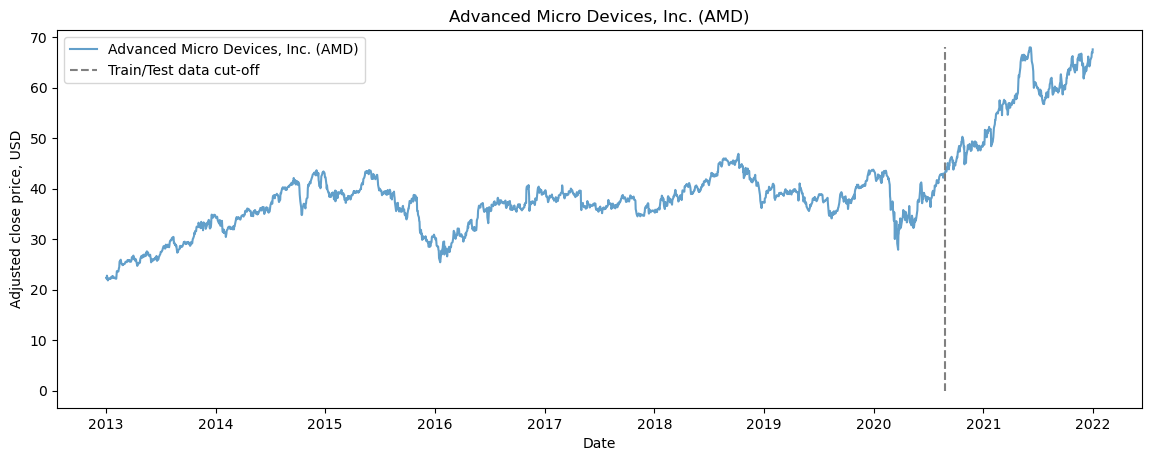

In [46]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(full_df['Date'], full_df['Adj Close'], label='Advanced Micro Devices, Inc. (AMD)', alpha = 0.7)
plt.vlines(datetime.date(year,month, day), 0, full_df['Adj Close'].max(), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Adjusted close price, USD')
plt.title('Advanced Micro Devices, Inc. (AMD)')
plt.legend()
plt.show()

In [47]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(3, 1, 1)
    plt.plot(dataset['ma_7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['ma_21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['Adj Close'],label='Adj Close', color='b')
    plt.plot(dataset['bolu'],label='Bollinger Upper Band', color='c')
    plt.plot(dataset['bold'],label='Bollinger Lower Band', color='c')
    plt.fill_between(x_, dataset['bolu'], dataset['bold'], alpha=0.35)
    plt.title('Technical indicators for Advanced Micro Devices, Inc. (AMD) - last {} days.'.format(last_days))
    plt.ylabel('Adjusted close price, USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(3, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['macd'],label='MACD', linestyle='-.')
    plt.hlines(5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-5, xmacd_, shape_0, colors='g', linestyles='--')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.title('RSI')
    plt.plot(dataset['rsi'],label='RSI', color='b',linestyle='-')
    plt.legend()
    
    plt.show()

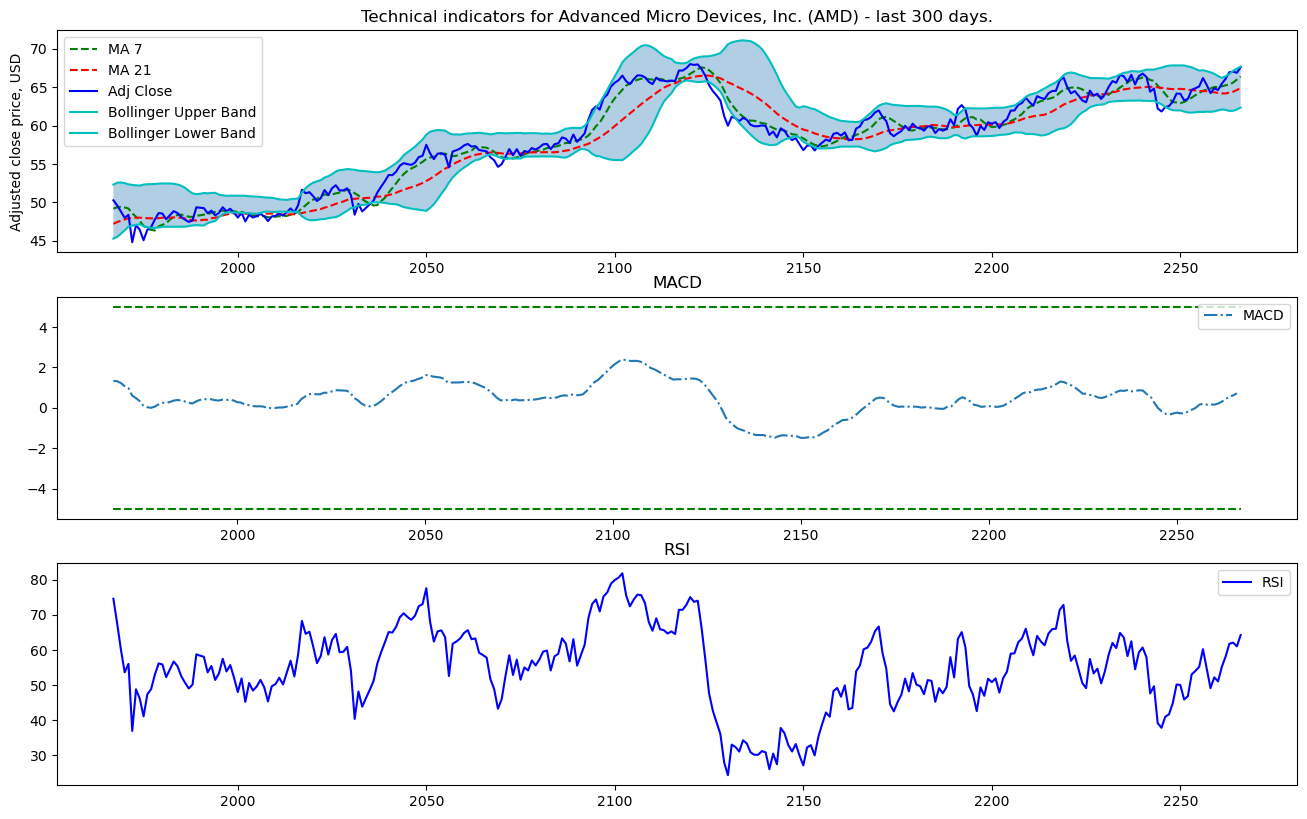

In [48]:
plot_technical_indicators(full_df, 300)

In [50]:
corr = full_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [83]:
print('Total dataset has {} samples, and {} column.'.format(full_df.shape[0], \
                                                              full_df.shape[1]))

Total dataset has 2267 samples, and 100 column.


# Feature Selection
## 1. Heteroskedastic analysis and serial correlation

In [51]:
def statistic(df, param):
    df = ct.add_constant(df)
    ivar = ["const"] + param
    reg = rg.OLS(df["Adj Close"], df[ivar], hasconst=bool).fit()
    res = reg.resid
    dw = durbin_watson(res)
    bplmt_statistic = np.round(dg.het_breuschpagan(res, exog_het = df[ivar])[0], 6)
    bplmt_p_value = np.round(dg.het_breuschpagan(res, exog_het = df[ivar])[1], 6)

    return bplmt_statistic, bplmt_p_value, dw, df[ivar]

In [52]:
parameters = []
for el in full_df.columns.tolist():
    if el != "Adj Close" and el != 'Date':
        parameters.append([el])

In [53]:
#https://www.youtube.com/watch?v=jy2OurbLFGg
#https://stats.stackexchange.com/questions/239060/interpretation-of-breusch-pagan-test-bptest-in-r/239062
#https://www.statsmodels.org/dev/_modules/statsmodels/stats/diagnostic.html#het_breuschpagan
# https://www.statsmodels.org/stable/_modules/statsmodels/stats/stattools.html#durbin_watson
# https://www.statology.org/durbin-watson-test-python/
param =  (parameters)
pairplot_list = []

for el in param:   
    col_names = ["Adj Close"] + el
    data_for_test = full_df[col_names]
    bp_statistic = statistic(data_for_test, el)[0]
    bp_pvalue = statistic(data_for_test, el)[1]
    dw = statistic(data_for_test, el)[2]
    if bp_pvalue>=0.05:# and (dw >= 1 and dw <= 3)
        pairplot_list.append(el[0])
        print("--------------------")
        print(f"Heteroskedastic analysis for {el}")
        print()
        print(f"Breusch-Pagan LM test statistic", statistic(data_for_test, el)[0])
        print("Breusch-Pagan LM test P-Value: ", statistic(data_for_test, el)[1])
        print("durbin_watson: ", statistic(data_for_test, el)[2]) 
        print()

--------------------
Heteroskedastic analysis for ['EURUSD=X']

Breusch-Pagan LM test statistic 1.64022
Breusch-Pagan LM test P-Value:  0.200295
durbin_watson:  0.004696193175470391

--------------------
Heteroskedastic analysis for ['GBPUSD=X']

Breusch-Pagan LM test statistic 2.719749
Breusch-Pagan LM test P-Value:  0.099114
durbin_watson:  0.00510067321725929

--------------------
Heteroskedastic analysis for ['JLCYX']

Breusch-Pagan LM test statistic 1.972502
Breusch-Pagan LM test P-Value:  0.160183
durbin_watson:  0.015934186096965192

--------------------
Heteroskedastic analysis for ['CNPIX']

Breusch-Pagan LM test statistic 2.798792
Breusch-Pagan LM test P-Value:  0.094335
durbin_watson:  0.016905701035710985

--------------------
Heteroskedastic analysis for ['OAKMX']

Breusch-Pagan LM test statistic 3.259796
Breusch-Pagan LM test P-Value:  0.070998
durbin_watson:  0.01577337329520005

--------------------
Heteroskedastic analysis for ['BPTRX']

Breusch-Pagan LM test statistic

In [94]:
print(pairplot_list, len(pairplot_list))

['EURUSD=X', 'GBPUSD=X', 'JLCYX', 'CNPIX', 'OAKMX', 'BPTRX', 'UOPIX', 'RYVLX', 'ACN', 'WFC', 'T', 'LOW', 'T10YIE'] 13


In [96]:
stat_most_important = pairplot_list

In [101]:
# Тази клетка не е генерирана, защото увеличава размера на файла!

# col_names = ["Adj Close"] + pairplot_list
# data_for_test = stock_df[col_names]
# sns.pairplot(statistic(data_for_test, pairplot_list)[3])

## 2. XGBoosting

In [75]:
def get_feature_importance_data(df):
    data = df.copy()
    y = data['Adj Close']
    data = data.drop('Adj Close', axis=1)
    X = data.iloc[:, 1:]
    X = (X - X.min ()) / (X.max () - X.min ())
   
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [76]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(full_df)

In [77]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [78]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [79]:
eval_result = regressor.evals_result()

In [80]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

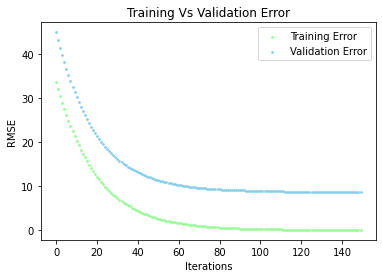

In [81]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error', color = "palegreen", s=3)
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error', color = "skyblue", s=3)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()
# Данните са много малко и модела няма достатъчно капацитет. 0,65  0,75  0,8 0,82 0,83  0,85  0.9  0.95--->train_samples

Text(0.5, 1.0, 'Top 30 features important')

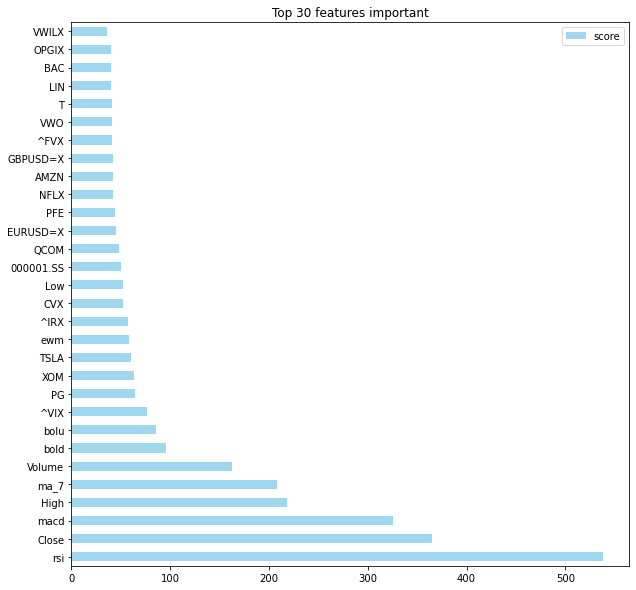

In [82]:
# https://matplotlib.org/stable/gallery/color/named_colors.html
feature_important = xgbModel.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(30, columns="score").plot(kind='barh', figsize = (10,10), color = 'skyblue', alpha = 0.8)
plt.title("Top 30 features important")
## plot top 30 features 

In [86]:
data.nlargest(30, columns="score").head(10)

,score
rsi,538.0
Close,365.0
macd,326.0
High,218.0
ma_7,208.0
Volume,163.0
bold,96.0
bolu,86.0
^VIX,76.0
PG,64.0


In [87]:
xgb_most_important_30 = (data.nlargest(30, columns="score")).index.tolist()
xgb_most_important_30

['rsi',
 'Close',
 'macd',
 'High',
 'ma_7',
 'Volume',
 'bold',
 'bolu',
 '^VIX',
 'PG',
 'XOM',
 'TSLA',
 'ewm',
 '^IRX',
 'CVX',
 'Low',
 '000001.SS',
 'QCOM',
 'EURUSD=X',
 'PFE',
 'NFLX',
 'AMZN',
 'GBPUSD=X',
 '^FVX',
 'VWO',
 'T',
 'LIN',
 'BAC',
 'OPGIX',
 'VWILX']

## 3. PCA

In [88]:
pca_df = full_df.drop('Adj Close', axis=1)
pca_df = full_df.drop('Date', axis=1)
pca_df

,Adj Close,High,Low,Open,Close,Volume,ewm,ma_7,ma_21,rsi,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,22.333015,28.680000,28.049999,28.139999,28.670000,6677100.0,21.331152,21.544037,21.318136,67.940932,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,22.153860,28.760000,28.299999,28.760000,28.440001,3970700.0,21.405943,21.617482,21.379340,64.147275,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,22.761452,29.290001,28.459999,28.500000,29.219999,5842400.0,21.529171,21.782178,21.472446,70.220399,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,21.818907,29.100000,27.930000,29.100000,28.010000,8339200.0,21.555511,21.842271,21.520297,54.732007,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,22.075964,28.360001,27.900000,27.930000,28.340000,3880400.0,21.602825,21.936860,21.580389,57.486147,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,66.070000,66.089996,65.250000,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,58.105626,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,66.930000,66.980003,66.000000,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,61.772180,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,67.010002,67.459999,66.870003,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,62.104439,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,66.860001,67.410004,66.830002,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,61.033303,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73


In [89]:
pca = PCA(n_components=.95)
x_pca = StandardScaler().fit_transform(pca_df)
principalComponents = pca.fit_transform(x_pca)
pca.explained_variance_ratio_

array([0.75236861, 0.06911566, 0.05717825, 0.03411429, 0.01979948,
       0.01228148, 0.00948875])

In [90]:
n_pcs= pca.components_.shape[0]
initial_feature_names = pca_df.columns
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['^GSPC', 'bold', '^IRX', 'EURUSD=X', 'rsi', 'T10YIE', 'Volume']

In [91]:
pca_most_important = most_important_names

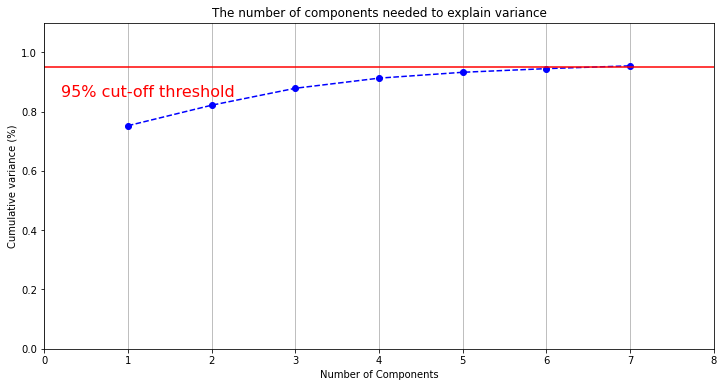

In [92]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(most_important_names)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(most_important_names)+2, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y = 0.95, color='r', linestyle='-')
plt.text(0.2, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

#  Prepare Dataset for Preprocessing

In [97]:
most_important_features = list(set(stat_most_important + xgb_most_important_30 + pca_most_important))

In [98]:
print(len(most_important_features), list(most_important_features))

41 ['XOM', 'Volume', 'BAC', 'bolu', '^VIX', '^GSPC', 'ma_7', 'OPGIX', 'CVX', 'JLCYX', 'AMZN', 'LIN', 'T', 'Low', 'CNPIX', 'bold', 'rsi', 'High', 'VWILX', 'macd', 'NFLX', 'UOPIX', '^FVX', 'PG', '000001.SS', 'GBPUSD=X', 'WFC', '^IRX', 'BPTRX', 'Close', 'QCOM', 'OAKMX', 'ACN', 'ewm', 'VWO', 'EURUSD=X', 'LOW', 'RYVLX', 'T10YIE', 'PFE', 'TSLA']


# Send Preprocessed Data to Files
## 1. Most Important features

In [99]:
dataset_most_important_feature = full_df[["Date","Adj Close" ] + most_important_features]
# dataset_most_important_feature.to_csv(r'data\data_for_time_series\dataset_most_important_feature.csv', index = False, header=True)
dataset_most_important_feature

,Date,Adj Close,XOM,Volume,BAC,bolu,^VIX,^GSPC,ma_7,OPGIX,...,OAKMX,ACN,ewm,VWO,EURUSD=X,LOW,RYVLX,T10YIE,PFE,TSLA
0,2013-01-02,22.333015,60.387547,6677100.0,10.460158,28.276532,14.680000,1462.420044,21.544037,21.018976,...,35.002926,57.524582,21.331152,35.663445,1.319784,30.915403,22.180546,1.64,17.725426,7.072000
1,2013-01-03,22.153860,60.278633,3970700.0,10.399290,28.441684,14.560000,1459.369995,21.617482,20.962923,...,34.911549,57.316322,21.405943,35.451668,1.318218,30.624966,21.948225,1.62,17.684381,6.954000
2,2013-01-04,22.761452,60.557713,5842400.0,10.529717,28.711065,13.830000,1466.469971,21.782178,21.025982,...,35.094296,57.632862,21.529171,35.514408,1.303271,30.394314,21.817141,1.63,17.759630,6.880000
3,2013-01-07,21.818907,59.856579,8339200.0,10.512328,28.761600,13.790000,1461.890015,21.842271,21.103052,...,34.988865,57.382957,21.555511,35.208527,1.306745,29.693823,21.814545,1.62,17.773319,6.868000
4,2013-01-08,22.075964,60.230972,3880400.0,10.416681,28.805516,13.620000,1457.150024,21.936860,21.011971,...,34.911549,57.716152,21.602825,34.918331,1.312508,29.710911,21.726290,1.71,17.800684,6.736000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,61.889999,1175900.0,44.639999,66.388560,17.680000,4791.189941,65.231429,75.089996,...,119.839996,414.255981,64.719121,49.340000,1.132426,252.866135,494.809998,2.02,59.200001,1093.939941
2263,2021-12-28,66.930000,61.689999,1049900.0,44.700001,66.711888,17.540001,4786.350098,65.340001,74.750000,...,119.860001,414.196137,64.920110,49.169998,1.133003,253.185089,490.130005,1.93,58.009998,1088.469971
2264,2021-12-29,67.010002,61.150002,1038500.0,44.630001,67.116617,16.950001,4793.060059,65.588573,74.500000,...,119.839996,414.345795,65.110100,48.959999,1.131478,256.723419,490.200012,1.96,57.580002,1086.189941
2265,2021-12-30,66.860001,60.790001,906900.0,44.529999,67.396706,17.330000,4778.729980,65.965716,74.379997,...,119.489998,412.759857,65.269182,49.590000,1.136015,255.547317,486.529999,2.00,58.400002,1070.339966


## 2. Dataset with all features

In [100]:
df = full_df[["Date", "Adj Close"]]
df1 = full_df.drop(["Date", "Adj Close"], axis=1)
rearanged_dataset = df.merge(df1, left_index=True,right_index=True)

dataset_full_features = rearanged_dataset
# dataset_full_features.to_csv(r'data\data_for_time_series\dataset_full_features.csv', index = False, header=True)
dataset_full_features

,Date,Adj Close,High,Low,Open,Close,Volume,ewm,ma_7,ma_21,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,2013-01-02,22.333015,28.680000,28.049999,28.139999,28.670000,6677100.0,21.331152,21.544037,21.318136,...,69.449501,20.130396,22.521328,28.374767,30.915403,93.433762,25.615805,13.006111,1.64,1.30
1,2013-01-03,22.153860,28.760000,28.299999,28.760000,28.440001,3970700.0,21.405943,21.617482,21.379340,...,69.842514,20.141891,22.751579,28.646267,30.624966,93.433762,25.282818,13.007962,1.62,1.28
2,2013-01-04,22.761452,29.290001,28.459999,28.500000,29.219999,5842400.0,21.529171,21.782178,21.472446,...,69.241432,20.262678,22.973143,28.675886,30.394314,94.064522,25.227316,13.072507,1.63,1.31
3,2013-01-07,21.818907,29.100000,27.930000,29.100000,28.010000,8339200.0,21.555511,21.842271,21.520297,...,70.058296,20.354708,23.007896,28.675886,29.693823,93.857025,25.306608,13.011653,1.62,1.28
4,2013-01-08,22.075964,28.360001,27.900000,27.930000,28.340000,3880400.0,21.602825,21.936860,21.580389,...,70.081436,20.010992,22.764624,28.473501,29.710911,94.512688,25.013260,13.149972,1.71,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-12-27,66.070000,66.089996,65.250000,65.540001,66.070000,1175900.0,64.719121,65.231429,64.166191,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.02,1.72
2263,2021-12-28,66.930000,66.980003,66.000000,66.000000,66.930000,1049900.0,64.920110,65.340001,64.286667,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,1.93,1.63
2264,2021-12-29,67.010002,67.459999,66.870003,67.050003,67.010002,1038500.0,65.110100,65.588573,64.391429,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,1.96,1.67
2265,2021-12-30,66.860001,67.410004,66.830002,67.199997,66.860001,906900.0,65.269182,65.965716,64.612857,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.00,1.73
